# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro

Let $\mathcal{G}$ be a graph with $n$ nodes, possibly directed, and let $\mathcal{G}_{sub}$ be another graph with $m<n$ nodes. 
Our problem is to find a subgraph of $\mathcal{G}$ which is as close as possible, according to some graph similarity metric $d(\cdot, \cdot)$ , to $\mathcal{G}_{sub}$.  For example, if $\mathcal{G}_{sub}$ consists of a subset of edges of $\mathcal{G}$ and their incident nodes, the problem is to identify those edges. 

For simplicity we shall phrase the problem in terms of identifying the nodes rather than the edges. Any node identification algorithm can be turned into an edge identification algorithm by applying it on the *line graphs* of $\mathcal{G}$ and $\mathcal{G}_{sub}$.  We also phrase the algorithm in terms of undirected graphs. In order to account for the direction, we apply an invertible symmetrization to the graphs as a pre-process, e.g., transforming the directed graph into an undirected bipartite graph.
 
Let $\mathbf{w}$ denote a discrete probability distribution on the nodes of  $\mathcal{G}$, i.e., $0\leq w_i \leq 1$ is the probability for sampling the node $i$ and $\sum_{i=1}^{n}{w_i} = 1$.  A vector $\mathbf{w}_{sub}$ representing the nodes of $\mathcal{G}_{sub}$ would be a uniform distribution on the nodes of $\mathcal{G}$ that is concentrated on the nodes of $\mathcal{G}_{sub}$, i.e., 

$$
\mathbf{w}_{sub}[i] = \begin{cases} 1/m &\;\;\;\;  i\in \mathcal{N}(\mathcal{G}_{sub})\\
 0 & \;\;\;\;otherwise.
 \end{cases}
$$
 
In order to optimize for $\mathbf{w}$, we define two functions:

- A node classification function $\texttt{classify}$ parametrized by $\theta$, which generates a vector $\mathbf{w}$ from $\mathcal{G}, \mathcal{G}_{sub}$, i.e.
$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub}; \theta)
$$

- A permutation invariant graph embedding function $\texttt{embed}$ parametrized by $\mathbf{\phi}$ which satisfies the following condition:

$$
$d\left(\texttt{embed}(\mathcal{G}, \mathbf{w}_{sub} ; \phi), $\texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1} ; \phi)\right) \approx 0  
$$

Our complete algorithm consists of optimizing for $\theta$ given $\phi$:

$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub} ; \theta)\\
\mathbf{v} = \texttt{embed}(\mathcal{G}, \mathbf{w}, ; \phi)\\
\mathbf{v}_{sub} = \texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1}, ; \phi)
$$

$$
\min_{\theta} d(\mathbf{v},\mathbf{v}_{sub})^2 + \rho \cdot \texttt{reg}(\mathcal{G}, \mathbf{w})
$$

The purpose of the $\texttt{reg}$ function is to promote $\mathbf{w}$ to be piecewise constant on the graph.

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    nn_subgraph_localization
from subgraph_matching_via_nn.graph_metric_networks.graph_matric_nn import \
    GraphMetricNetwork
from subgraph_matching_via_nn.composite_nn.compiste_nn import CompositeNeuralNetwork
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import \
    NNNodeClassifierNetwork, IdentityNodeClassifierNetwork, GCNNodeClassifierNetwork
from subgraph_matching_via_nn.utils.utils import uniform_dist, NP_DTYPE, TORCH_DTYPE
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_nn import \
    MomentEmbeddingNetwork, SpectralEmbeddingNetwork
import torch
from subgraph_matching_via_nn.utils.utils import plot_degree_distribution, \
    plot_graph_with_colors
from subgraph_matching_via_nn.utils.utils import plot_indicator
from torch import tensor
import kmeans1d
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
from subgraph_matching_via_nn.data.data_loaders import load_graph
from subgraph_matching_via_nn.data.paths import *

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)

In [10]:
from subgraph_matching_via_nn.data.paths import DATA_PATH

# Set the size of the graph and the subgraph
n = 20  # Number of nodes in the graph (for random graph)
m = 7  # Number of nodes in the subgraph (for random graph)
seed = 10  # for plotting
loader_params = {'graph_size': n,
                 'subgraph_size': m,
                 'data_path' : DATA_PATH,
                 'g_full_path': COMP2_FULL_path,
                 'g_sub_path': COMP2_SUB0_path}

G, G_sub, w_indicator, edge_indicator = \
    load_graph(type='subcircuit',
               loader_params=loader_params)  # type = 'random', 'example', 'subcircuit'

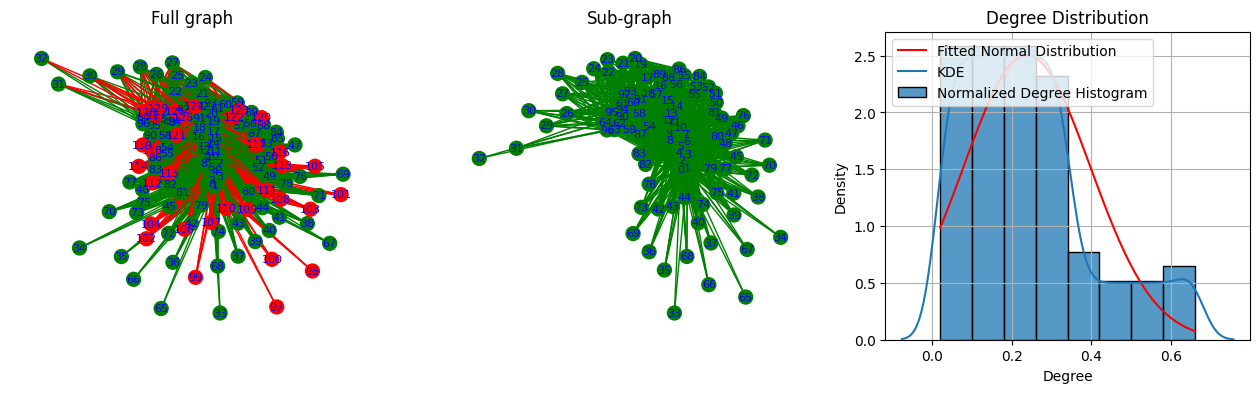

First 4 moments: ['0.2381', '0.0821', '0.0353', '0.0174', '0.0094', '0.0053']


In [11]:

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=G, G_sub=G_sub, distribution=edge_indicator, ax=axes[0],
                       colorbar=False, title='Full graph', seed=seed, draw_labels=True)
plot_graph_with_colors(G=G_sub, G_sub=G_sub, ax=axes[1], colorbar=False,
                       title='Sub-graph', seed=seed, draw_labels=True)
# Plot degree distribution and compute first 4 moments
n_moments = 6
moments = plot_degree_distribution(G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

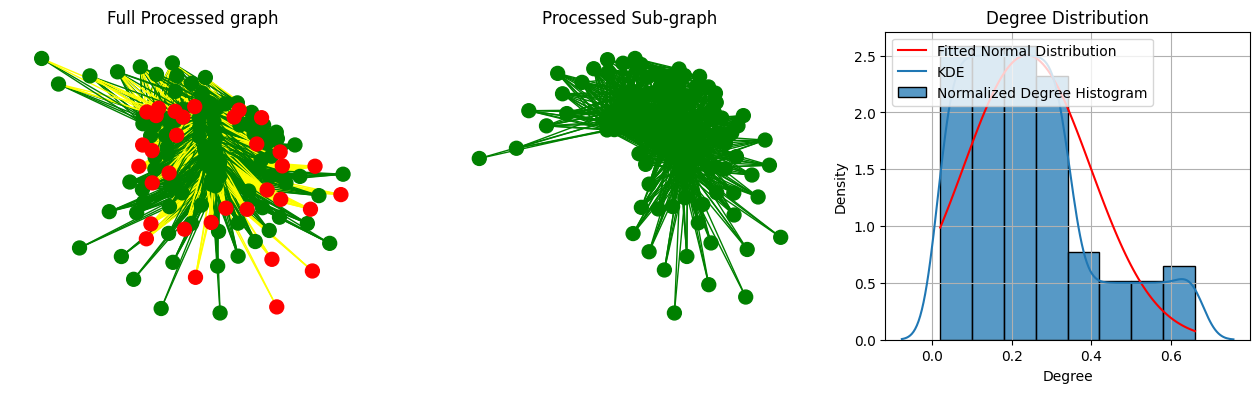

First 4 moments: ['0.2381', '0.0821', '0.0353', '0.0174', '0.0094', '0.0053']


In [12]:
# Transform to line
to_line = False
graph_processor_params = {'to_line':  to_line}
graph_processor = GraphProcessor(params=graph_processor_params)
processed_G, gt_node_indicator_processed = graph_processor.pre_process(G, edge_indicator, w_indicator)
processed_G_sub = graph_processor.pre_process(G_sub)

# gt_node_indicator_line = np.array(
#     [edge_indicator[edge] for edge in processed_G.nodes()])

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=processed_G, G_sub=processed_G_sub,
                       distribution=gt_node_indicator_processed,
                       ax=axes[0], colorbar=False, title='Full Processed graph', seed=seed,
                       draw_labels=False)
plot_graph_with_colors(G=processed_G_sub, G_sub=processed_G_sub, ax=axes[1],
                       colorbar=False,
                       title='Processed Sub-graph', seed=seed, draw_labels=False)
# Plot degree distribution and compute first 4 moments
n_moments = 6
moments = plot_degree_distribution(processed_G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

In [16]:
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import \
    sigmoid_layer, squared_normalized_layer, softmax_layer
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    binary_penalty, graph_entropy, spectral_reg, graph_total_variation

# --------- split -----------
# Assuming you have your graph G and subgraph G_sub defined
w_gt = (tensor(w_indicator)[:, None].float() / tensor(w_indicator).sum()).type(
    TORCH_DTYPE)
A_full = torch.from_numpy(nx.to_numpy_array(G)).type(TORCH_DTYPE)
A_sub = torch.from_numpy((nx.adjacency_matrix(G_sub)).toarray()).type(TORCH_DTYPE)
params = {}
params["maxiter"] = 5000
params["lr"] = 0.0000002  # 0.0002 is good
params["n_moments"] = 6
params["n_eigs"] = 6
params["m"] = len(G_sub.edges()) if to_line else len(G_sub.nodes)  #
params["reg_param"] = 0.01  # reg param  # 0.02  is good
params["k_update_plot"] = 250
params['spectral_op_type'] = 'Hamiltonian'
params["moment_type"] = "standardized_raw"  
# options: 'central' ,'raw', 'standardized_raw', 'standardized_central'
params["reg_term"] = binary_penalty
# Example usage
input_dim = len(G.edges()) if to_line else len(G.nodes)  # Input feature dimension
hidden_dim = 20  # Hidden dimension
output_dim = len(G.edges()) if to_line else len(G.nodes)  #
last_layer = squared_normalized_layer
# node_classifier_network = NNNodeClassifierNetwork(input_dim=input_dim,
#                                                   hidden_dim=hidden_dim,
#                                                   output_dim=output_dim,
#                                                   learnable_sigmoid=False,
#                                                   default_sigmoid_param_value=1.0,
#                                                   last_layer=last_layer
#                                                   )
node_classifier_network = IdentityNodeClassifierNetwork(input_dim=input_dim,
                                                        learnable_sigmoid=False,
                                                        default_value_sigmoid_param=1.0,
                                                        last_layer=last_layer)
# node_classifier_network = GCNNodeClassifierNetwork(input_dim=1,
#                                       hidden_dim=hidden_dim,
#                                       num_classes=1,
#                                       learnable_sigmoid=True,
#                                       default_value_sigmoid_param=1)
node_classifier_network.train_node_classifier(G_sub=G_sub, graph_generator=None)
# embedding_nn = MomentEmbeddingNetwork(n_moments=params["n_moments"],
#                                       moments_type=params["moment_type"])


evals,_ = torch.linalg.eigh(SpectralEmbeddingNetwork.laplacian(A_sub))
params['diagonal_scale'] = 2*torch.max(evals)

embedding_nn = SpectralEmbeddingNetwork(n_eigs=params["n_eigs"],
                                       spectral_op_type=params['spectral_op_type'],
                                        diagonal_scale=params['diagonal_scale'], 
                                        indicator_scale=params["m"])
composite_nn = CompositeNeuralNetwork(node_classifier_network=node_classifier_network,
                                      embedding_network=embedding_nn)

loss_fun = torch.nn.MSELoss()
graph_metric_nn = GraphMetricNetwork(loss_fun=loss_fun)


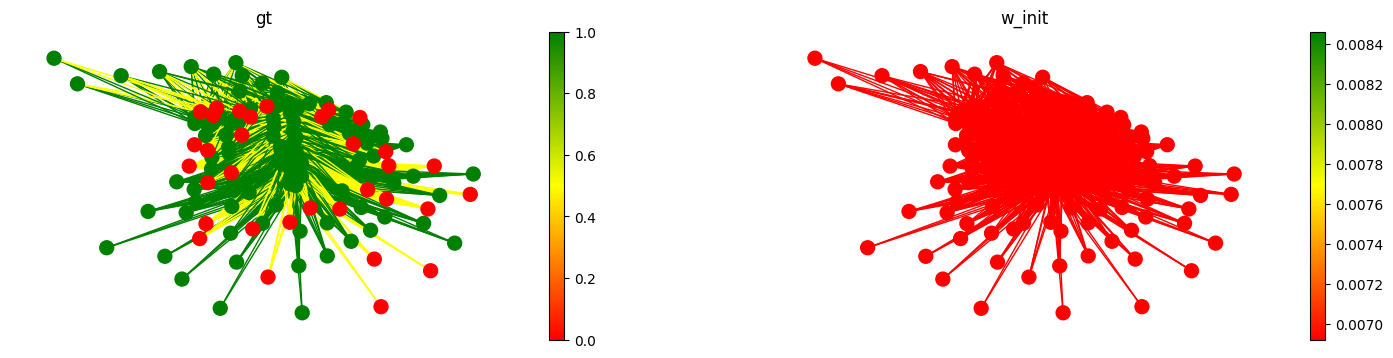

['36.8091', '38.7913', '38.8091', '38.8091', '39.7780', '39.8091'] : init standardized_raw moments
['0.0000', '1.9270', '2.0000', '2.0000', '2.9587', '3.0000'] : sub standardized_raw moments
init loss (no reg): 1355.714566700557
init full loss (with reg): 1355.7145667690424


In [17]:


# --------- split here-----------


# Initialize the parameters
# TODO: move to function into compositeNN class
#x0 = w_gt.clone() + 0.01*torch.rand(w_gt.shape, dtype=TORCH_DTYPE)
A_full_processed = torch.from_numpy((nx.adjacency_matrix(processed_G)).toarray()).type(
    TORCH_DTYPE)
A_sub_processed = torch.from_numpy(
    (nx.adjacency_matrix(processed_G_sub)).toarray()).type(TORCH_DTYPE)

edge_mask_gt = tensor(gt_node_indicator_processed)[:, None].type(TORCH_DTYPE)
edge_mask_gt = edge_mask_gt / edge_mask_gt.sum()
x0 = (1 * edge_mask_gt.clone() + 
      0.0 * (torch.rand(edge_mask_gt.shape, dtype=TORCH_DTYPE) - 0.5))
x0 = x0 / torch.sum(x0)
#composite_nn.node_classifier_network.init_params(default_weights=x0)
w_init = composite_nn.node_classifier_network.forward(A_full_processed).detach().numpy()
w_init_dict = dict(zip(processed_G.nodes(), w_init))

# print(f"x0 = {x0.detach().numpy().T}")
# print(f"gt = {edge_mask_gt.detach().numpy().T}")
# print(f"nn params = {w_init.T}")

fig, axes = plt.subplots(1, 2, figsize=[18, 4])
gt_indicator = edge_indicator if to_line else  w_indicator
w_init_indicator = w_init_dict if to_line else np.array(list(w_init_dict.values()))

plot_graph_with_colors(G=G, G_sub=G_sub, title='gt', distribution=gt_indicator,ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, title='w_init', distribution=w_init_indicator,ax=axes[1], seed=seed)

plt.show()

# compute loss and embedding at init

embedding_full, w = composite_nn(A_full_processed)
embedding_sub = composite_nn.embedding_network(
    A=A_sub_processed.detach().type(TORCH_DTYPE),
    w=uniform_dist(A_sub_processed.shape[0]).detach())
loss = graph_metric_nn(embedding_full=embedding_full,
                       embedding_subgraph=embedding_sub)

embedding_gt = composite_nn.embedding_network(
    A=A_full_processed.detach().type(TORCH_DTYPE),
    w=edge_mask_gt)

print(
    f"{[f'{value:.4f}' for value in embedding_full]} : init {params['moment_type']} moments")
print(
    f"{[f'{value:.4f}' for value in embedding_sub]} : sub {params['moment_type']} moments")
w_all = []

print(f"init loss (no reg): {loss}")  # without regularization
reg = params["reg_term"](A_full_processed, w, params)
full_loss = loss + params["reg_param"] * reg
print(f"init full loss (with reg): {full_loss}")  # with regularization
# --------- split here-----------


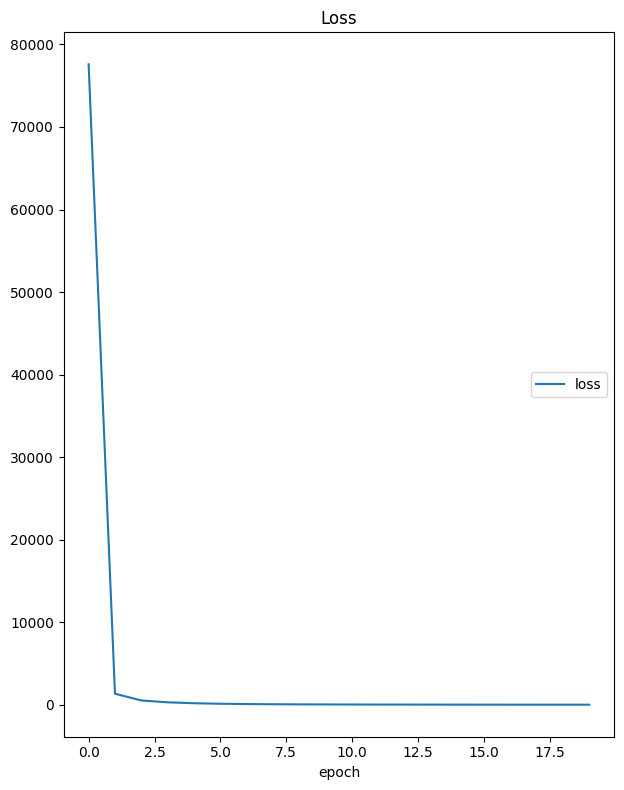

Loss
	loss             	 (min:   13.075, max: 77588.259, cur:   13.075)
4


In [18]:

num_rand_exp = 5
plt.figure(figsize=(3, 2))
for k in range(num_rand_exp):
    # TODO: how do I initialize all network params?
    # params["x0"] = x0/torch.sum(x0)
    # params["x0"] = w_gt.T

    x0 = (0*edge_mask_gt.clone() + 1 * (torch.rand(edge_mask_gt.shape, dtype=TORCH_DTYPE)-0.5))
    x0 = x0/torch.sum(x0)
    composite_nn.node_classifier_network.init_params(default_weights=x0)
    nn_subgraph_localization(G=G,
                             G_sub=G_sub,
                             composite_nn=composite_nn,
                             graph_metric_nn=graph_metric_nn,
                             graph_processor=graph_processor,
                             params=params,
                             )
    opt_mask = node_classifier_network.forward(A_full).detach()
    w_star = opt_mask.numpy()
    w_all.append(w_star)
    print(k)


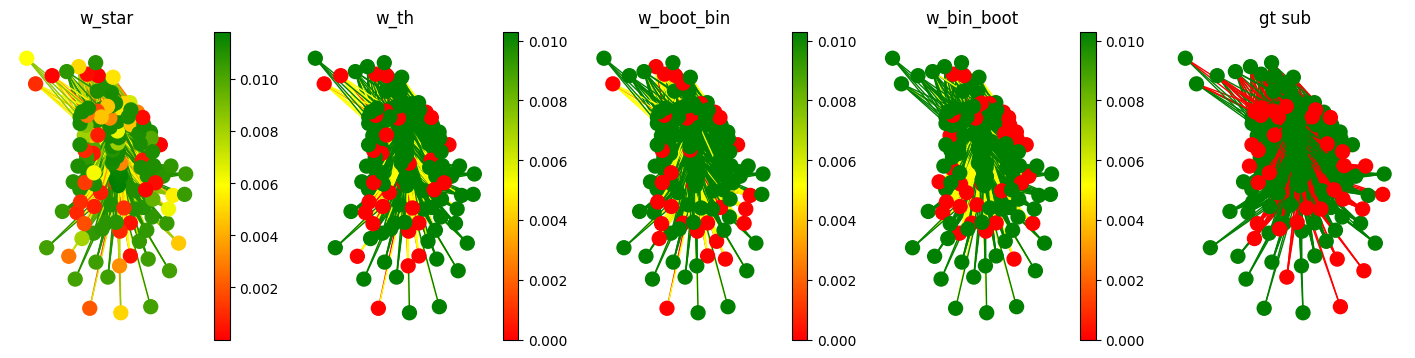

['0.0000', '1.9270', '2.0000', '2.0000', '2.9587', '3.0000'] : sub standardized_raw moments 
['0.0000', '1.9270', '2.0000', '2.0000', '2.9587', '3.0000'] : gt standardized_raw moments 
['-8.3743', '0.9404', '2.0999', '2.2430', '2.3056', '2.3331'] : est standardized_raw moments
['0.0000', '0.9915', '1.0000', '1.9717', '2.0000', '2.0000'] : est standardized_raw moments_th
['-0.0000', '0.9924', '1.0000', '1.9749', '2.0000', '2.0000'] : est standardized_raw moments_boot_th
['0.0000', '0.9848', '1.0000', '1.0000', '1.9647', '2.0000'] : est standardized_raw moments_bin_boot_th
loss = 12.006994148525395, reg_param = 0.01, reg_term = binary_penalty


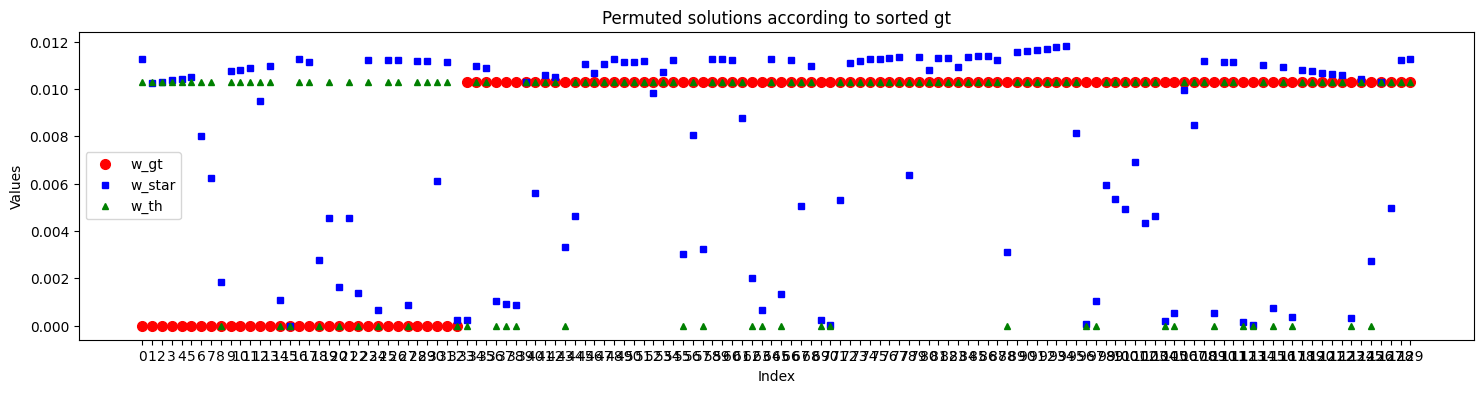

In [19]:
def binarize(graph: nx.graph, w: np.array, params, type):
    if type=='k_means':
        w_th, centroids = kmeans1d.cluster(w, k=2)
        w_th = np.array(w_th)[:,None]
    elif type=='top_m':
        indices_of_top_m = np.argsort(w, axis=0)[-params["m"]:]  # top m
        w_th = np.zeros_like(w, dtype=NP_DTYPE)
        w_th[indices_of_top_m] = 1
    elif type=='quantile':         
        w_th = (w_star>np.quantile(w_star, (n-m)/n))
        w_th = np.array(w_th, dtype=np.float64)
    w_th = w_th / w_th.sum()
    w_th_dict = dict(zip(graph.nodes(), w_th))

    return w_th_dict

binarization_type = 'top_m'

A_full_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G))).type(TORCH_DTYPE)
A_sub_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G_sub))).type(TORCH_DTYPE)

opt_mask = node_classifier_network.forward(A_full_processed).detach()
w_star = opt_mask.numpy()
w_star_dict = dict(zip(processed_G.nodes(), w_star))

w_th_dict = binarize(processed_G, w_star, params, binarization_type)

w_boot = np.mean(np.array(w_all), axis=0)
w_boot = w_boot / w_boot.sum()
w_boot_dict = dict(zip(processed_G.nodes(), w_boot))

w_boot_dict_th = binarize(processed_G, w_boot, params, binarization_type)

w_binarize_boot_dict = binarize(processed_G, np.median(
    np.array([list(binarize(processed_G, w, params, binarization_type).values()) for w in w_all]), axis=0),
                                params, binarization_type)

est_moments = embedding_nn(w=tensor(w_star, requires_grad=False),
                           A=A_full_processed.detach()).type(TORCH_DTYPE)
est_moments_th = embedding_nn(w=tensor(list(w_th_dict.values()), requires_grad=False),
                              A=A_full_processed).type(TORCH_DTYPE)
est_moments_boot_th = embedding_nn(
    w=tensor(list(w_boot_dict_th.values()), requires_grad=False),
    A=A_full_processed).type(TORCH_DTYPE)
est_moments_bin_boot_th = embedding_nn(
    w=tensor(list(w_binarize_boot_dict.values()), requires_grad=False),
    A=A_full_processed).type(TORCH_DTYPE)

fig, axes = plt.subplots(1, 5, figsize=[18, 4])

indicator_w_star = w_star_dict if to_line else w_star
indicator_w_th = w_th_dict if to_line else np.array(list(w_th_dict.values()))
indicator_w_boot_th = w_boot_dict_th if to_line else np.array(list(w_boot_dict_th.values()))
indicator_w_binarize_boot = w_binarize_boot_dict if to_line else np.array(list(w_binarize_boot_dict.values()))


plot_graph_with_colors(G=G, G_sub=G_sub, distribution=indicator_w_star, title='w_star',
                       ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, distribution=indicator_w_th, title='w_th',
                       ax=axes[1], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, distribution=indicator_w_boot_th,
                       title='w_boot_bin',
                       ax=axes[2], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, distribution=indicator_w_binarize_boot,
                       title='w_bin_boot',
                       ax=axes[3], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, title='gt sub', ax=axes[4], seed=seed)
plt.show()

# turn indicator into tensor and normalize to get distribution on nodes of line graph
gt_node_distribution_processed = tensor(gt_node_indicator_processed)[:, None].type(TORCH_DTYPE)
gt_node_distribution_processed = gt_node_distribution_processed / torch.sum(
    gt_node_distribution_processed)
embedding, _ = composite_nn(A_full_processed)
embedding_sub = composite_nn.embedding_network(
    A=A_sub_processed.detach().type(TORCH_DTYPE),
    w=uniform_dist(A_sub_processed.shape[0]).detach())
embedding_gt = composite_nn.embedding_network(
    A=A_full_processed.detach().type(TORCH_DTYPE),
    w=gt_node_distribution_processed)
print(
    f"{[f'{value:.4f}' for value in embedding_sub]} : sub {params['moment_type']} moments ")
print(
    f"{[f'{value:.4f}' for value in embedding_gt]} : gt {params['moment_type']} moments ")
print(
    f"{[f'{value:.4f}' for value in est_moments]} : est {params['moment_type']} moments")
print(
    f"{[f'{value:.4f}' for value in est_moments_th]} : est {params['moment_type']} moments_th")
print(
    f"{[f'{value:.4f}' for value in est_moments_boot_th]} : est {params['moment_type']} moments_boot_th")
print(
    f"{[f'{value:.4f}' for value in est_moments_bin_boot_th]} : est {params['moment_type']} moments_bin_boot_th")

loss = graph_metric_nn(embedding, embedding_gt)
print(
    f"loss = {loss}, reg_param = {params['reg_param']}, reg_term = {params['reg_term'].__name__}")

fig, ax = plt.subplots(1, 1, figsize=[18, 4])
plot_indicator([gt_node_distribution_processed, w_star, np.array(list(w_th_dict.values()))], ['w_gt', 'w_star', 'w_th'], ax)